In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

#Dataset Information

In [11]:
data = pd.read_csv('/content/AirPassengers.csv')

In [12]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [13]:
print('data shape is',data.shape)
print(data.dtypes)
print(data.isnull().sum())

data shape is (144, 2)
Month          object
#Passengers     int64
dtype: object
Month          0
#Passengers    0
dtype: int64


In [14]:
data.describe()

,#Passengers
count,144.00
mean,280.30
std,119.97
min,104.00
25%,180.00
50%,265.50
75%,360.50
max,622.00


In [15]:
data['Date'] = pd.to_datetime(data['Month'])
data = data.drop(columns = 'Month')
data = data.set_index('Date')
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#Time Series Analysis

<Axes: xlabel='Date', ylabel='Passengers'>

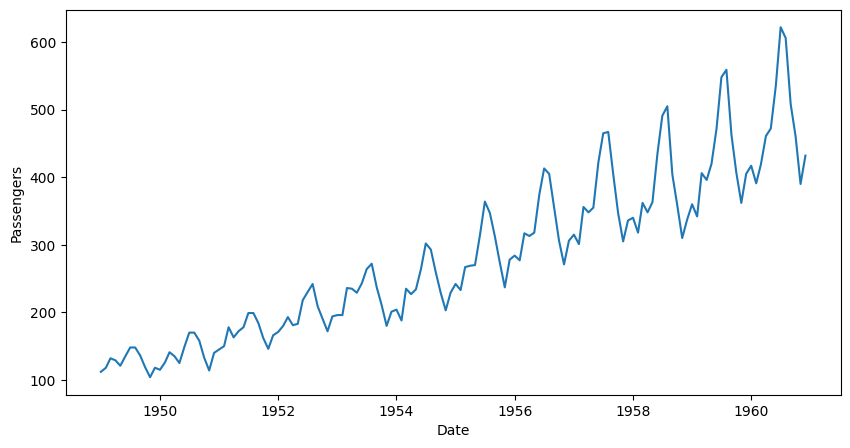

In [16]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data,x=data.index,y=data.Passengers)


Dickey–Fuller test: p=0.991880


<Figure size 1500x700 with 0 Axes>

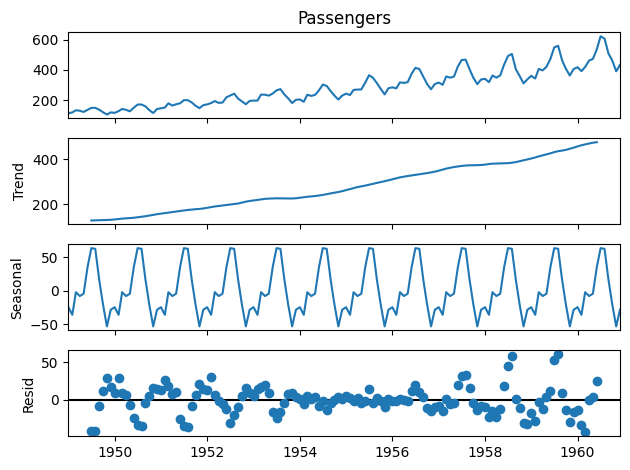

In [17]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(data.Passengers).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.Passengers)[1])
plt.show()

In [18]:
data['rollMean']  = data.Passengers.rolling(window=12).mean()
data['rollStd']  = data.Passengers.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

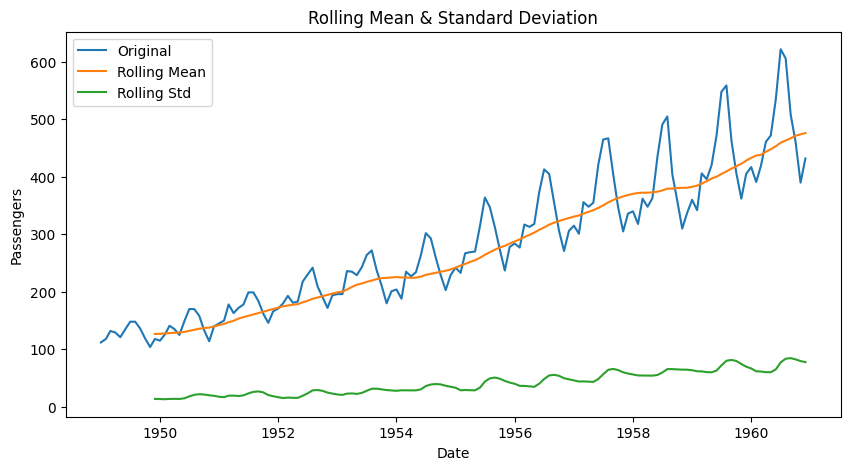

In [19]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data,x=data.index,y=data.Passengers ,label='Original')
sns.lineplot(data=data,x=data.index,y=data.rollMean ,label='Rolling Mean')
sns.lineplot(data=data,x=data.index,y=data.rollStd ,label = 'Rolling Std')
plt.title('Rolling Mean & Standard Deviation')

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the **ADCF test**.

In [20]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')

dftest = adfuller(data['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

#Data Transformation to achieve Stationarity

There are a couple of ways to achieve stationarity through data transformation like taking  log10
 , loge
 , square, square root, cube, cube root, exponential decay, time shift and so on ...

In [21]:
def test_stationarity(dataFrame, var):
    dataFrame = pd.DataFrame({var: dataFrame})

    dataFrame['rollMean']  = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd']  = dataFrame[var].rolling(window=12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var],autolag='AIC')
    stats = pd.Series(adfTest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    print(stats)

    for key, values in adfTest[4].items():
        print('criticality',key,":",values)

    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var ,label='Original')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollMean' ,label='Rolling mean')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollStd',label = 'Rolling Std')

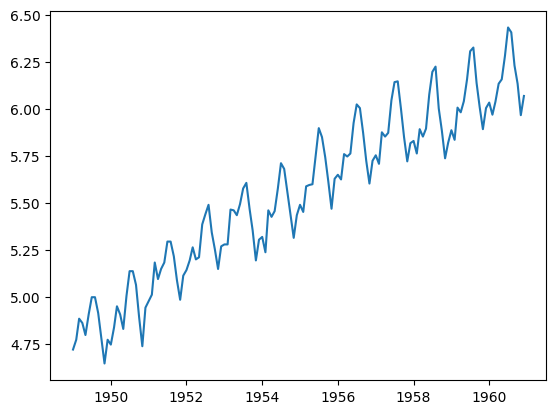

In [22]:
logdata = np.log(data['Passengers'])
plt.plot(logdata)

In [23]:
logdata.head()

,Passengers
Date,
1949-01-01,4.72
1949-02-01,4.77
1949-03-01,4.88
1949-04-01,4.86
1949-05-01,4.80


Test Statistic                 -1.72
p-value                         0.42
#lags used                     13.00
number of observations used   130.00
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


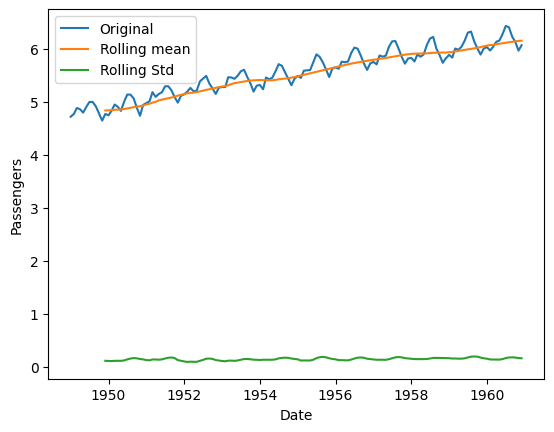

In [24]:
test_stationarity(logdata, 'Passengers')

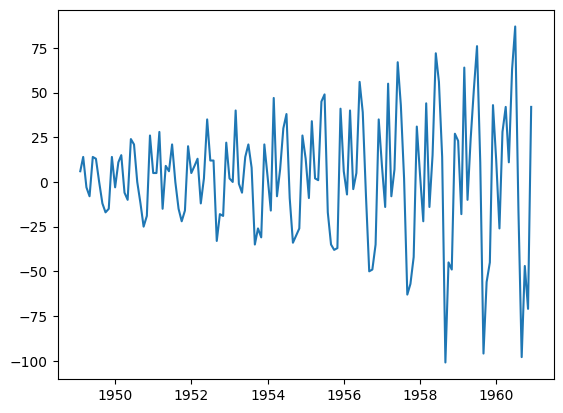

In [25]:
diffdata = data['Passengers'].diff()
plt.plot(diffdata)

In [26]:
diffdata.dropna(inplace=True)
diffdata.head()

,Passengers
Date,
1949-02-01,6.00
1949-03-01,14.00
1949-04-01,-3.00
1949-05-01,-8.00
1949-06-01,14.00


Test Statistic                 -2.83
p-value                         0.05
#lags used                     12.00
number of observations used   130.00
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


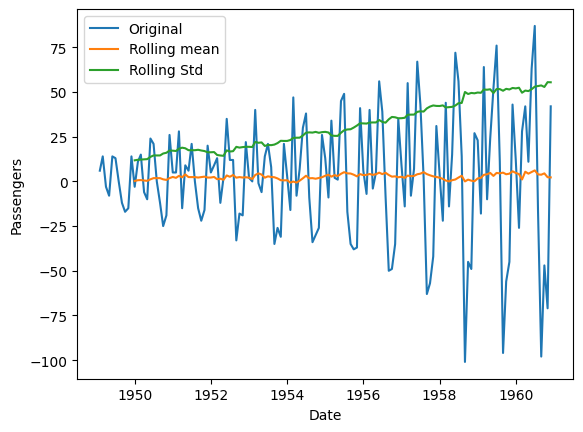

In [27]:
test_stationarity(diffdata, 'Passengers')

#Modeling ARIMA

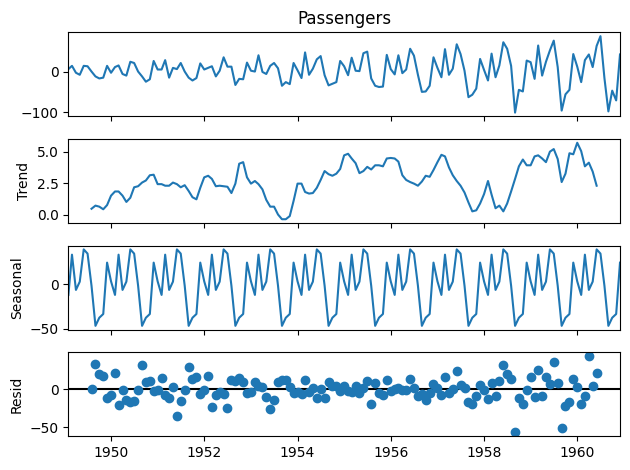

In [28]:
dec = sm.tsa.seasonal_decompose(diffdata,period = 12).plot()
plt.show()

In [29]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

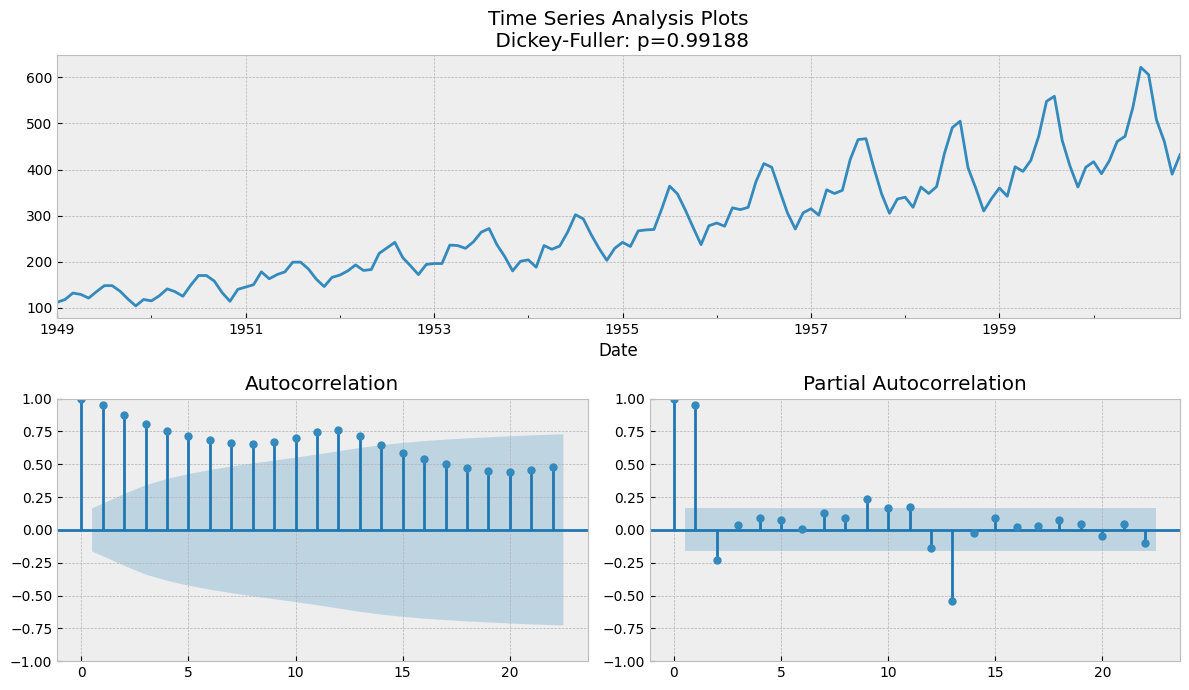

In [30]:
tsplot(data['Passengers'])

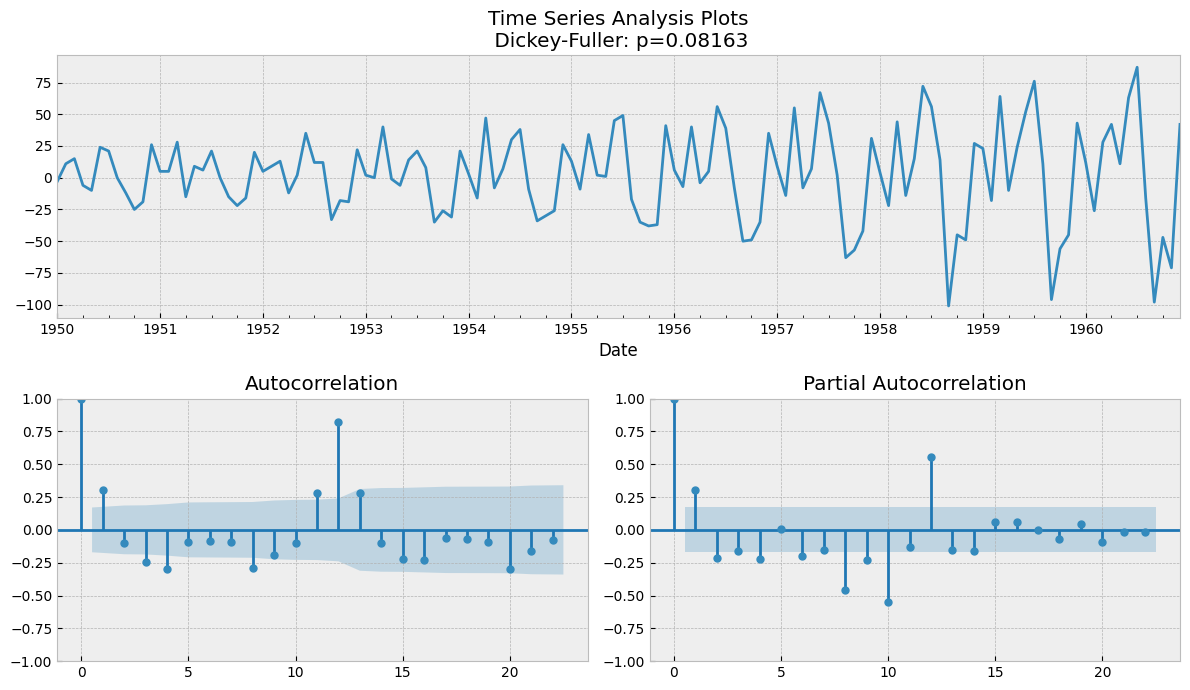

In [31]:
data_diff = data.diff()
data_diff.dropna(inplace=True)
data_diff.head()
tsplot(data_diff['Passengers'])

In [37]:
# from statsmodels.tsa.arima.model import ARIMA
# model = ARIMA(data['Passengers'],order = (3,2,1))
# model_fit = model.fit()
# print(model_fit.summary())
model = SARIMAX(data['Passengers'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
# Fit the SARIMA model using only the 'Passengers' column
model = SARIMAX(data['Passengers'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Summary of the model's performance
print(results.summary())

# Forecasting
forecast = results.forecast(steps=12)  # Forecasting 12 months ahead

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Sat, 14 Sep 2024   AIC                           1022.299
Time:                                    21:54:19   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2148      0.325   

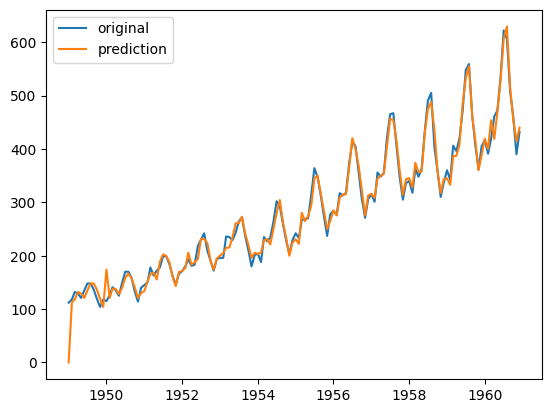

In [38]:
# Use the `predict` method and matplotlib to generate the plot
predictions = model_fit.predict(dynamic=False)
plt.plot(data['Passengers'] , label = 'original')
plt.plot(predictions , label = 'prediction')
plt.legend()
plt.show()
data['arimaPred'] = predictions

In [39]:
train, test = data['Passengers'][:100], data['Passengers'][100:]


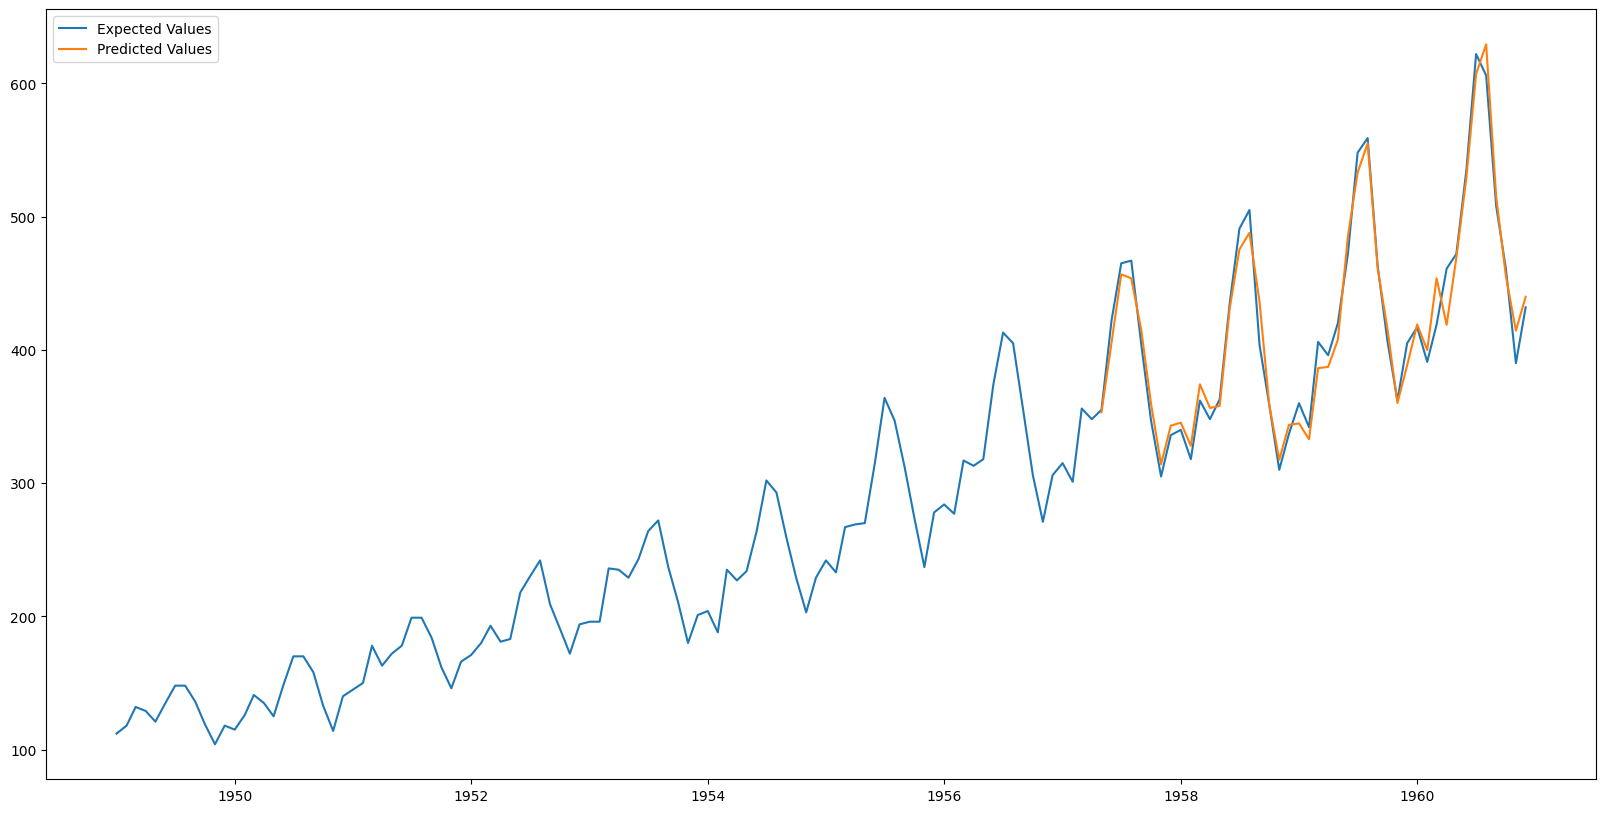

In [40]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


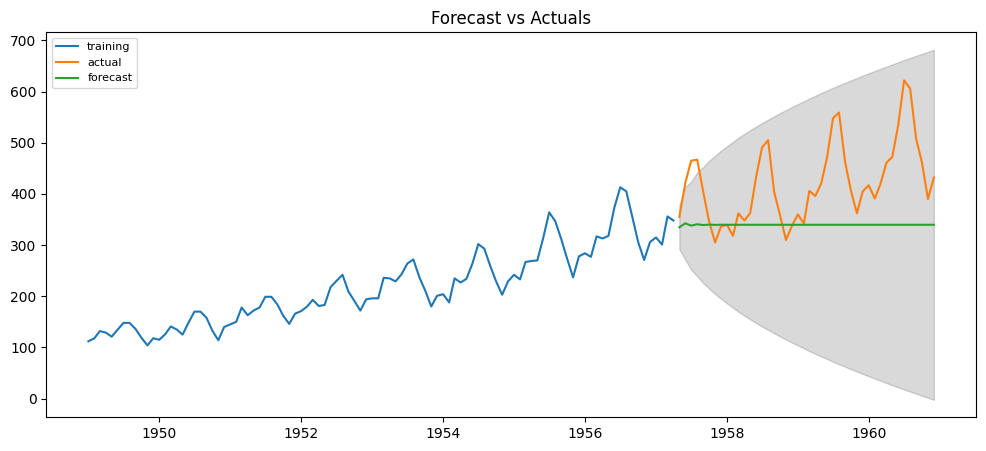

In [42]:
# Build Model
# model = ARIMA(train, order=(3,2,1))
model = SARIMAX(train, order=(1, 1, 1))
fitted = model.fit()  # Removed disp argument

# Forecast
fc = fitted.forecast(119, alpha=0.05)  # 95% conf
# get confidence intervals
conf = fitted.get_forecast(119).conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [43]:
futureDate = pd.DataFrame(pd.date_range(start='1961-01-01', end='1972-12-01',freq='MS'),columns=['Dates'])
futureDate.set_index('Dates',inplace=True)
futureDate.head(10)


""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01
1961-06-01
1961-07-01
1961-08-01
1961-09-01


In [44]:
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1])

,predicted_mean
1961-01-01,449.33
1961-02-01,424.39
1961-03-01,459.04
1961-04-01,497.87
1961-05-01,509.87
...,...
1972-08-01,1014.00
1972-09-01,916.99
1972-10-01,869.18
1972-11-01,798.77


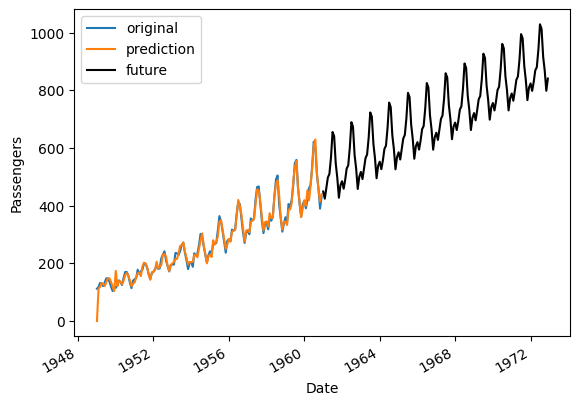

In [45]:
data.dropna()
sns.lineplot(data=data,x=data.index,y='Passengers', label='original')
sns.lineplot(data=data,x=data.index,y='arimaPred', label ='prediction')
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1]).plot(color='black' , label='future')
plt.legend()

In [56]:
error = np.sqrt(mean_squared_error(test,predictions_series))
print('Test RMSE: %.4f' % error)


Test RMSE: 14.5631


In [60]:
import numpy as np

# Replace 'actual_data' with your actual data
actual_data = np.array(test)

# Calculate the mean of the actual data
mean_value = np.mean(actual_data)

# Test RMSE value
rmse = 14.5631

# Calculate RMSE as a percentage of the mean
rmse_percentage = (rmse / mean_value) * 100

print(f"RMSE as a percentage of the mean: {rmse_percentage:.2f}%")

RMSE as a percentage of the mean: 3.46%
